In [1]:
import numpy as np

from utils import *

from IO.read_stereo import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [2]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df, bin_size=200)
adata = get_anndata(df)

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

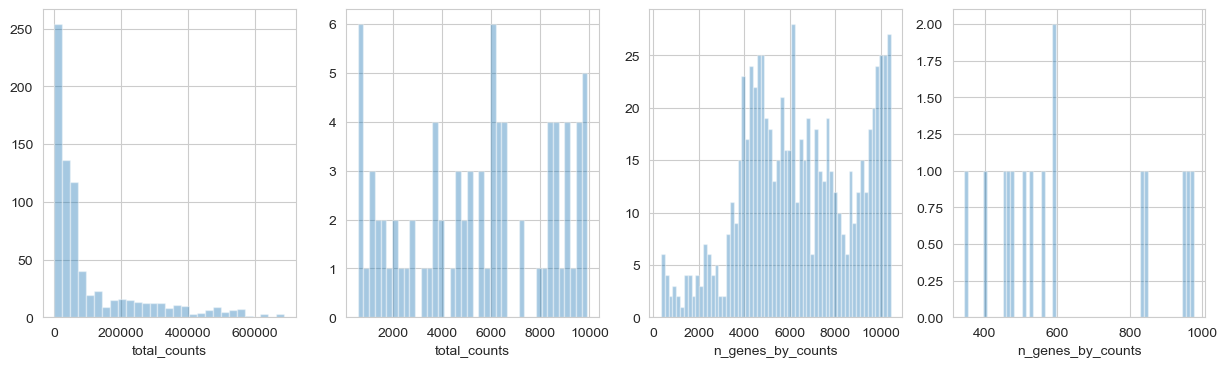

In [3]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=200)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [4]:
adata

AnnData object with n_obs × n_vars = 769 × 10792
    obs: 'cell_id', 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [5]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=1000)
gene_list = list(adata.var[adata.var['highly_variable']].index)

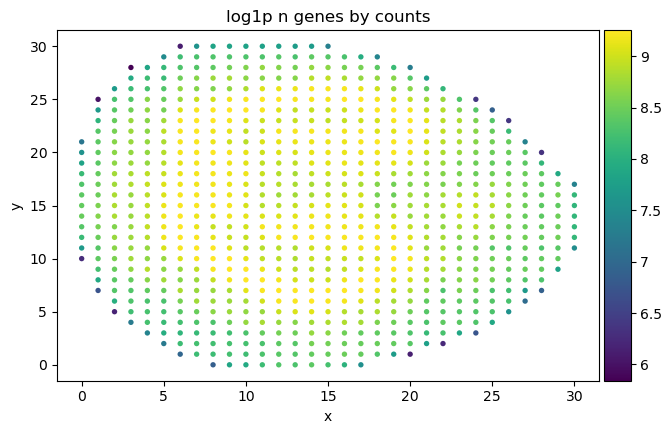

In [43]:
sc.pl.scatter(adata,
              x='x',
              y='y',
              color='log1p_n_genes_by_counts',
              size=60,
              palette=['#FF0000', '#00FF00', '#0000FF'])

<AxesSubplot:ylabel='Count'>

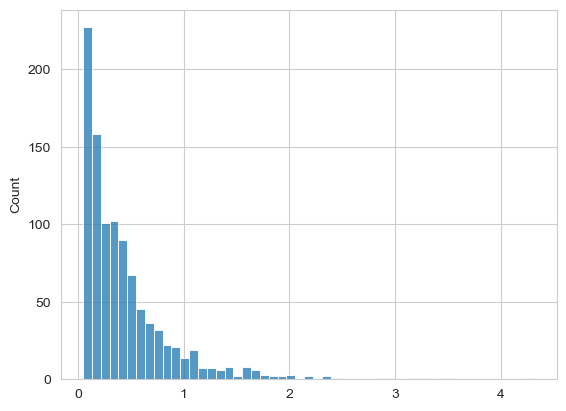

In [181]:
var = []
new_list = []
gene_list = list(adata.var[adata.var['highly_variable']].index)
for i in gene_list:
    v = np.var(get_exp_array(adata, i))
    var.append(v)
    if v > .9:
        new_list.append(i)
sns.histplot(var)

In [182]:
gmm_dict = fit_gmms(adata, new_list, n_comp=20)

Fitting...: 100%|██████████| 115/115 [00:11<00:00,  9.86it/s]


In [133]:
new_dict = gmm_dict.copy()
for i in gmm_dict:
    top = sorted(gmm_dict[i].weights_, reverse=True)[:3]
    if sum(top) < 1/20 * 3 * 1.5:
        new_dict.pop(i)
len(new_dict.keys())
gmm_dict = new_dict

In [183]:
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]


In [200]:
result = cluster(arr, n_clusters=8, mds_components=20, method='kmeans')

In [147]:
b = arr['AMEX60DD003014'].sort_values()
list(b.index[:8])

KeyError: 'AMEX60DD003014'

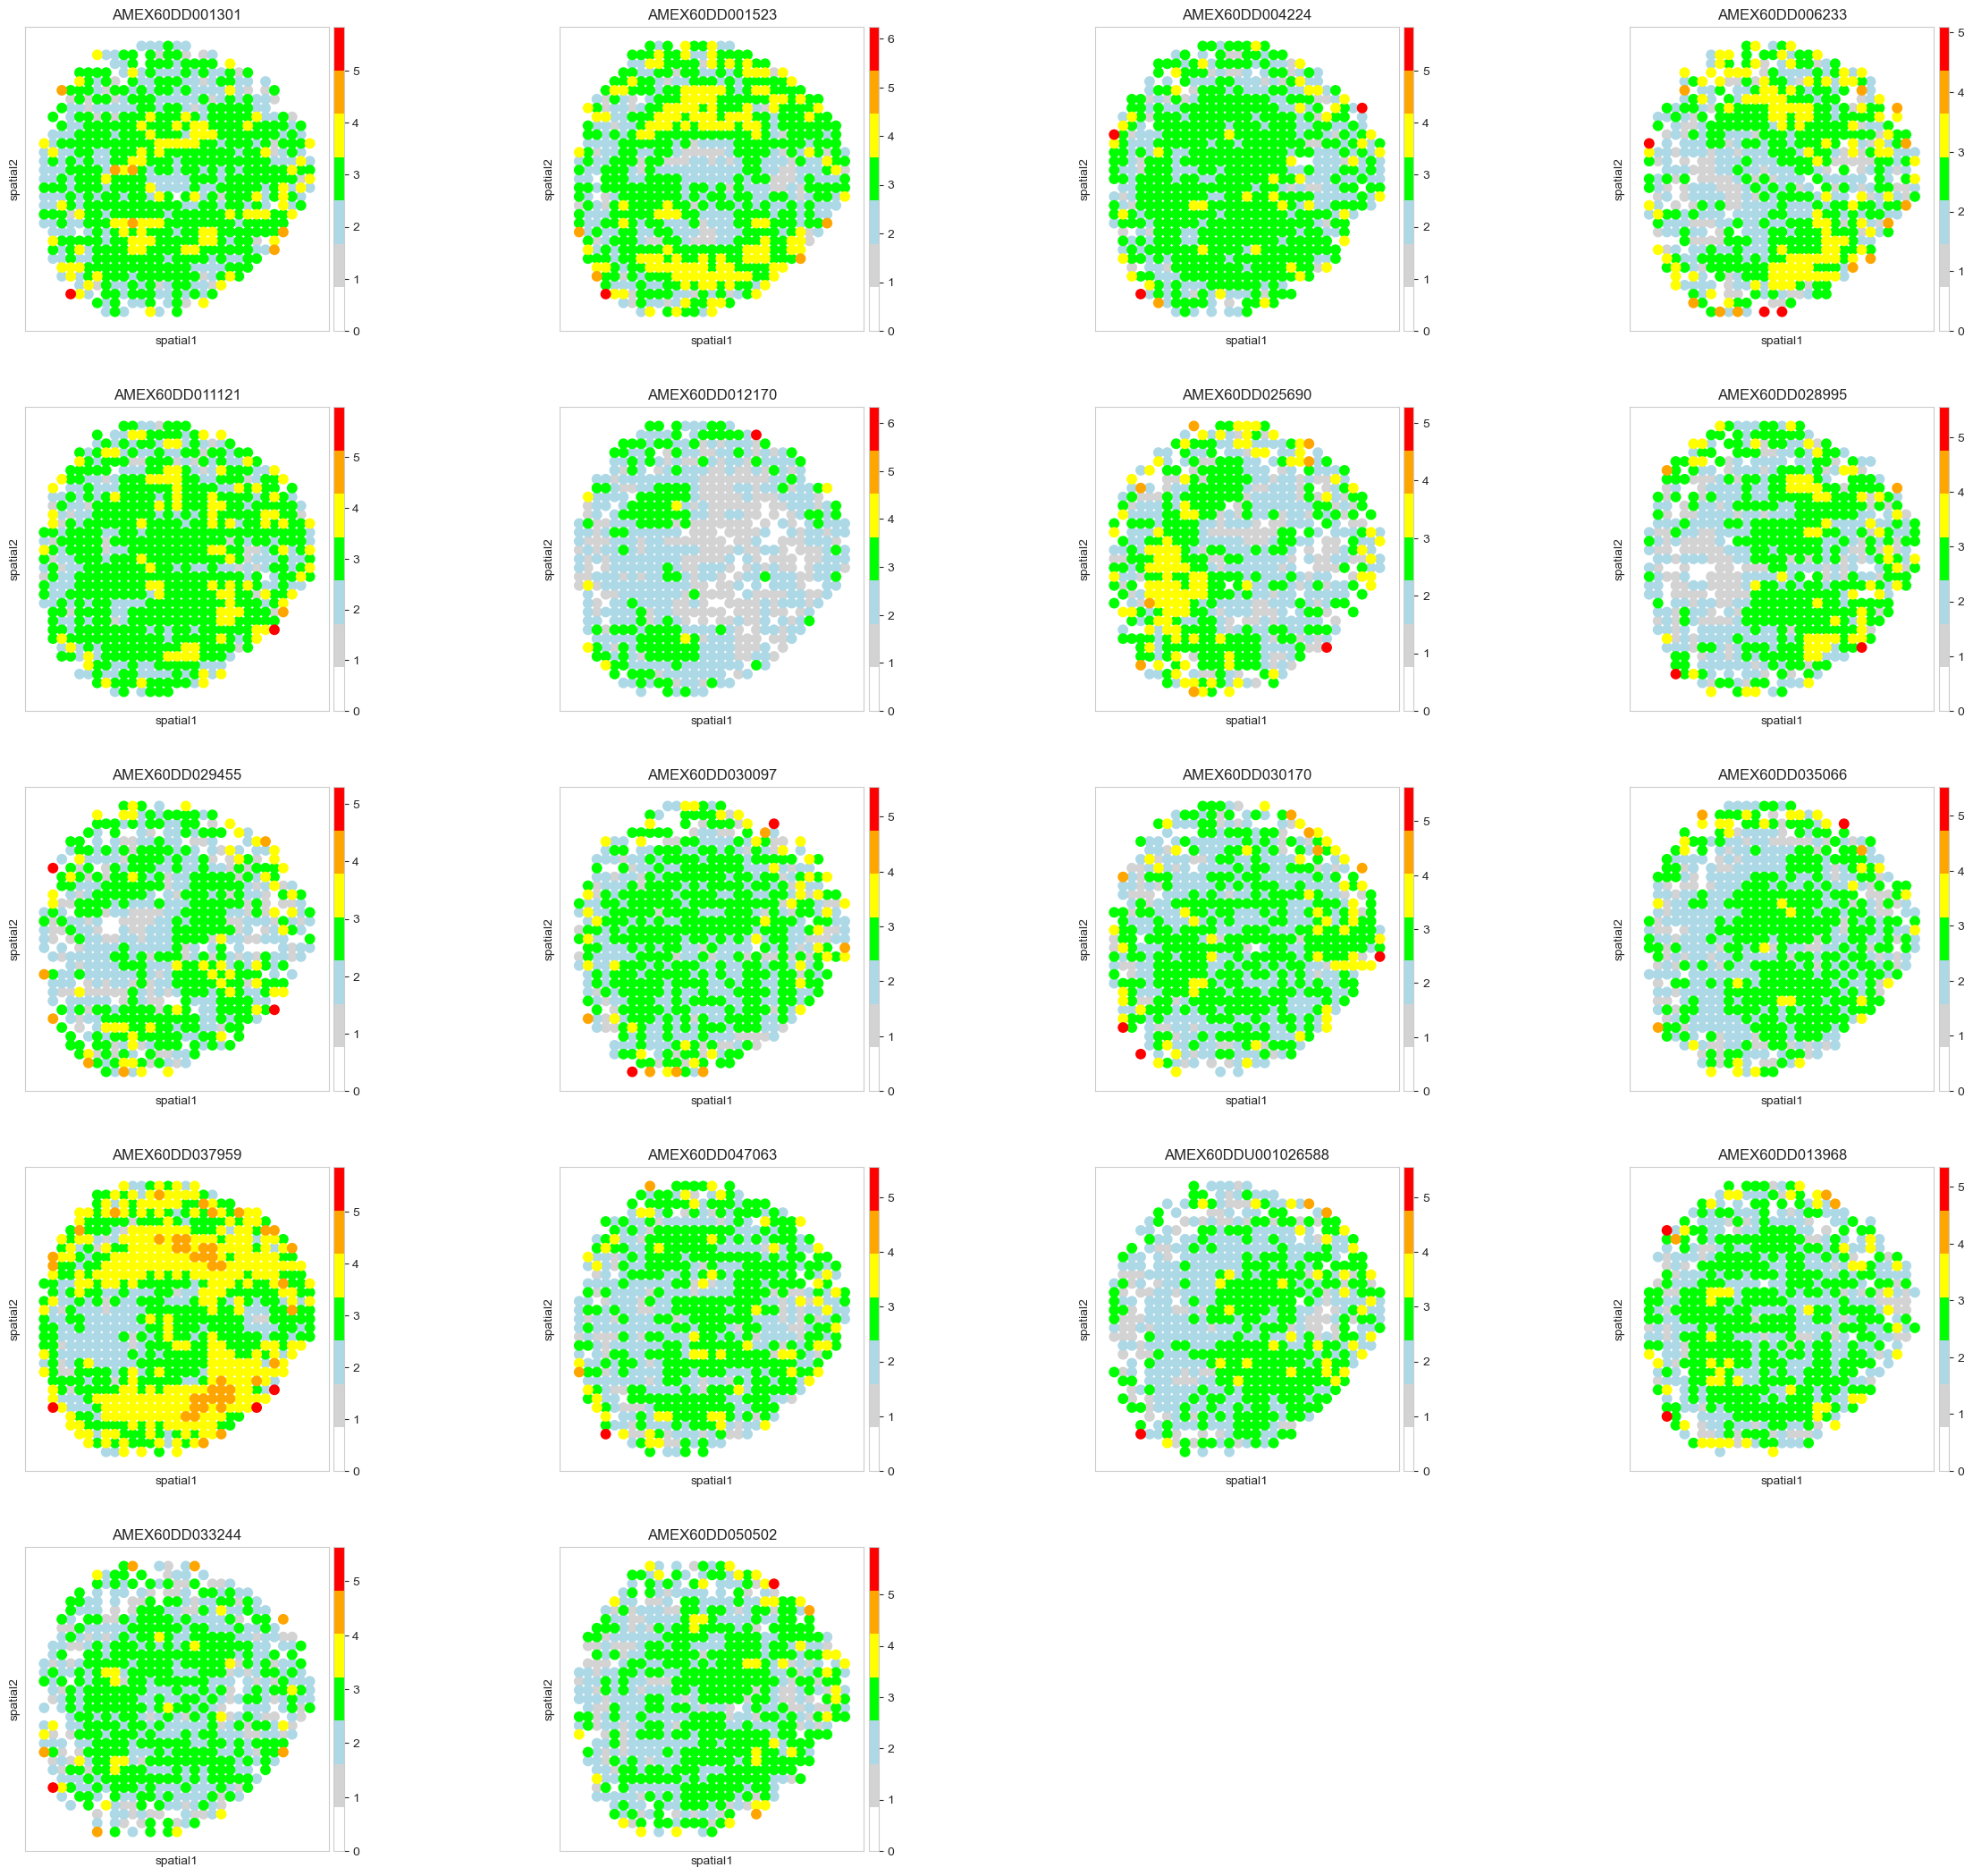

In [212]:
import scanpy as sc
import matplotlib.colors as colors

new_colors = ['white','lightgrey','lightblue', '#00FF00', '#FFFF00', '#FFA500', '#FF0000']
new_cmap = colors.ListedColormap(new_colors)
sc.pl.spatial(adata,
              spot_size=1.2,
              cmap=new_cmap,
              # color= list(b.index[:30])
              color=list(result[result['labels'] == 7]['gene_id'])
              )

In [205]:
print(np.var(get_exp_array(adata, 'AMEX60DD040693')))
print(np.var(get_exp_array(adata, 'AMEX60DD047270')))
print(np.var(get_exp_array(adata, 'AMEX60DD004224')))

1.2168385992305535
1.1361950621588464
1.2224995425117566


In [204]:
list(result[result['labels'] == 7]['gene_id'])

['AMEX60DD001301',
 'AMEX60DD001523',
 'AMEX60DD004224',
 'AMEX60DD006233',
 'AMEX60DD011121',
 'AMEX60DD012170',
 'AMEX60DD025690',
 'AMEX60DD028995',
 'AMEX60DD029455',
 'AMEX60DD030097',
 'AMEX60DD030170',
 'AMEX60DD035066',
 'AMEX60DD037959',
 'AMEX60DD047063',
 'AMEX60DDU001026588',
 'AMEX60DD013968',
 'AMEX60DD033244',
 'AMEX60DD050502']

In [211]:
np.var(np.array([[1, 1], [6, 0]]))

5.5

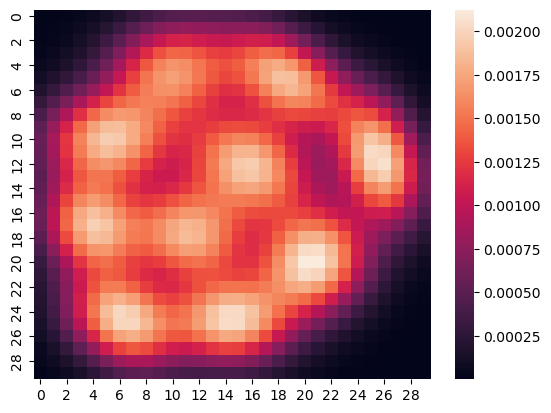

In [10]:
a = fit_gmm(adata, 'AMEX60DD004224', n_comp=10)
view_gmm(a, (0, 30))

In [56]:
get_exp_array(adata, 'AMEX60DD004224')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 2, 3, 3, 2, 0, 2, 2, 2, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 1,
        2, 1, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0,
        1, 2, 3, 1, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 0, 2, 0, 5, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 1,
        2, 3, 2, 2, 2, 3, 2, 0, 0],
       [0, 0, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 4, 0],
       [0, 0, 2, 0, 1, 3, 1, 1, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2,
        3, 3, 2, 1, 1, 2, 2, 2, 0],
       [0, 1, 3, 3, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 2, 2, 2, 3, 0, 1, 2, 2, 3, 3, 3, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2,
        2, 2, 3, 2, 3, 2, 1, 3, 3],
       [0,

In [64]:
list(result[result['labels'] == 8]['gene_id'])

['AMEX60DD014975',
 'AMEX60DD014991',
 'AMEX60DD016339',
 'AMEX60DD017201',
 'AMEX60DD021526',
 'AMEX60DD022398',
 'AMEX60DD025550',
 'AMEX60DD026264',
 'AMEX60DD027978',
 'AMEX60DD027994',
 'AMEX60DD029362',
 'AMEX60DD031873',
 'AMEX60DD039992',
 'AMEX60DD041991',
 'AMEX60DD042310',
 'AMEX60DD042921',
 'AMEX60DD048179',
 'AMEX60DD050542',
 'AMEX60DD052412',
 'AMEX60DD052620',
 'AMEX60DD007586',
 'AMEX60DD007589',
 'AMEX60DD008343',
 'AMEX60DD010100',
 'AMEX60DD025220',
 'AMEX60DD038981',
 'AMEX60DD049364',
 'AMEX60DD052517',
 'AMEX60DD055165',
 'AMEX60DD006662',
 'AMEX60DD007096',
 'AMEX60DD026246',
 'AMEX60DD028125',
 'AMEX60DD032055',
 'AMEX60DD033627',
 'AMEX60DD047161',
 'AMEX60DD001514',
 'AMEX60DD001970',
 'AMEX60DD005615',
 'AMEX60DD009563',
 'AMEX60DD020285',
 'AMEX60DD030219',
 'AMEX60DD031941',
 'AMEX60DD030644',
 'AMEX60DD029369',
 'AMEX60DD031152',
 'AMEX60DD039724',
 'AMEX60DD038449',
 'AMEX60DDU001010905']